# Assignment 10
### Due July 4 at 12:00

**This notebook contains interactive widgets. 
They work on the standard editors *jupyter-notebook* and *jupyter-lab*, but we have no experience for other editors.**

Please note: 

- Read the instructions in the exercise PDF and in this notebook carefully.
- Add your solutions *only* at `YOUR CODE HERE`/`YOUR ANSWER HERE` and remove the corresponding `raise NotImplementedError()`.
- Do not chance the provided code and text, if not stated.
- Do not *add* or *delete* cells.
- Do not `import` additional functionality. 
- Before submitting: Please make sure, that your notebook can be executed from top to bottom `Menu -> Kernel -> Restart & Run all`. 

## Exercise 2: Similarity Graphs

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact, fixed
import ipywidgets as widgets

from numpy.testing import assert_equal, assert_almost_equal
from sklearn.datasets import make_moons
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns
import sklearn.neighbors
import scipy.sparse.csgraph

In [2]:
# Generate the two moons datasets
n_samples = 100
X_moons, y_moons = make_moons(n_samples=n_samples, noise=0, shuffle=False, random_state=42)
X_noisy_moons, y_noisy_moons = make_moons(n_samples=n_samples, noise=0.15, shuffle=False, random_state=42)

# Shuffle points inside each class
_ = np.random.shuffle(X_moons[:int(n_samples/2)]), np.random.shuffle(X_moons[int(n_samples/2):])
_ = np.random.shuffle(X_noisy_moons[:int(n_samples/2)]), np.random.shuffle(X_noisy_moons[int(n_samples/2):])

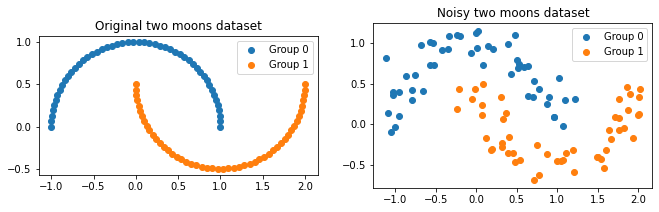

In [3]:
# Visualize the datasets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.scatter(X_moons[y_moons==0, 0], X_moons[y_moons==0, 1], label='Group 0')
ax1.scatter(X_moons[y_moons==1, 0], X_moons[y_moons==1, 1], label='Group 1')
ax1.set_title('Original two moons dataset')
ax1.legend()
ax1.set_aspect('equal')

ax2.scatter(X_noisy_moons[y_noisy_moons==0, 0], X_noisy_moons[y_noisy_moons==0, 1], label='Group 0')
ax2.scatter(X_noisy_moons[y_noisy_moons==1, 0], X_noisy_moons[y_noisy_moons==1, 1], label='Group 1')
ax2.set_title('Noisy two moons dataset')
ax2.legend()
ax2.set_aspect('equal')

plt.show()

### (a) 
Implement  the  function `plot_similarities(X, sigma)` to  compute  the  paired  similarities with a Gaussian kernel and show them as a heat map.

In [4]:
def plot_similarities(X, sigma):
    ''' 
    Plot the paired similarities with a Gaussian kernel,
    by using a heat map.
        
    Parameters
    ----------
    X: input matrix
    sigma: kernel parameter
    '''
    K = np.zeros((X.shape[0], X.shape[0]))
    for i, X_i in enumerate(X):
        for j, X_j in enumerate(X):
            K[i,j] = np.exp(- np.linalg.norm(X_i - X_j)**2 / (2 * sigma**2))
    
    
    #ax.set_title('Heatmap of similarity values')
    plt.gca().set_aspect('equal')
    plt.imshow(K)
    plt.show()

In [5]:
sigma_props = dict(min=-2, max=2, step=0.1, value=10**.5, continuous_update=False)

inter = interact(plot_similarities, X=fixed(X_moons), sigma=widgets.FloatLogSlider(**sigma_props));
inter = interact(plot_similarities, X=fixed(X_noisy_moons), sigma=widgets.FloatLogSlider(**sigma_props));

interactive(children=(FloatLogSlider(value=3.1622776601683795, continuous_update=False, description='sigma', m…

interactive(children=(FloatLogSlider(value=3.1622776601683795, continuous_update=False, description='sigma', m…

- **Which values of $\sigma$ would you choose, and why?**  
 For both datasets, a value of $\sigma \approx 0.5$ seems to give a good tradeoff of high similarity within each moon and low similarity between them.
    
- **What is the role of noise, how does it influence your choice of $\sigma$?**  
The noise makes the similarity difference (within vs between) less clear and thus the dataset much harder. In this case however, it does not change the seemingly best value for sigma

### (b) 
Now implement the function `plot_graph(X, k, mutual)`, which uses `sklearn.neighbors.kneighbors_graph` to create a graph and plots the adjacency matrix. Based on the parameter `mutual`, the graph should be either symmetric or mutual.

In [6]:
def unbalanced_gaussian(n_samples = 100, n_dimension = 200, ratio=0.2):
    """ Generate unbalanced Gaussian dataset """
    n_class_0 = int(n_samples * ratio)

    png = np.random.RandomState(42)
    X_unb_gaussian = png.normal(0, .6, size=(n_samples, n_dimension))
    X_unb_gaussian[:n_class_0, :2] -= 1.1
    X_unb_gaussian[n_class_0:, :2] += 1.

    y_unb_gaussian = np.zeros((n_samples, ))
    y_unb_gaussian[:n_class_0] = 0
    y_unb_gaussian[n_class_0:] = 1
    
    return X_unb_gaussian, y_unb_gaussian

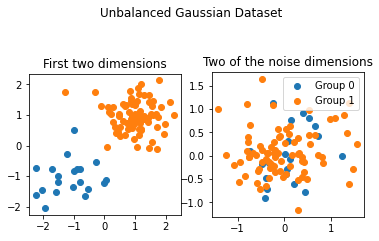

In [7]:
# Visualize the Gaussian datasets
X_unb_gaussian, y_unb_gaussian = unbalanced_gaussian(n_dimension=200)

plt.subplot(121, aspect='equal')
plt.scatter(X_unb_gaussian[y_unb_gaussian==0, 0], X_unb_gaussian[y_unb_gaussian==0, 1], label='Group 0')
plt.scatter(X_unb_gaussian[y_unb_gaussian==1, 0], X_unb_gaussian[y_unb_gaussian==1, 1], label='Group 1')
plt.title('First two dimensions')

plt.subplot(122, aspect='equal')
plt.scatter(X_unb_gaussian[y_unb_gaussian==0, 2], X_unb_gaussian[y_unb_gaussian==0, 3], label='Group 0')
plt.scatter(X_unb_gaussian[y_unb_gaussian==1, 2], X_unb_gaussian[y_unb_gaussian==1, 3], label='Group 1')
plt.title('Two of the noise dimensions')

plt.suptitle('Unbalanced Gaussian Dataset')
plt.legend()

plt.show()

In [8]:
def plot_graph(X, k=3, dim=2, mutual=False):
    ''' 
    Plot the adjacency matrix of a graph created 
    by using the function kneighbors_graph of sklearn.neighbors.
        
    Parameters
    ----------
    X: input matrix (n, d)
    k: number of neighbors for each sample
    dim: number of dimensions to use
    mutual: boolean parameter for choosing mutual kNN or symmetric kNN
    '''
    # A is the adjancency matrix (n, n)
    A = np.zeros((X.shape[0], X.shape[0]))
    X = X[:, :dim]
    
    # fill and plot adjacency matrix
    plt.subplot(121, aspect='equal')

    A = sklearn.neighbors.kneighbors_graph(X, k, include_self=False).toarray()
    
    if mutual:
        A = np.minimum(A, A.T)
    else:
        A = np.maximum(A, A.T)
    
    n_connected, _ = scipy.sparse.csgraph.connected_components(A)
    
    if mutual:
        plt.title('Adjacency Matrix mutual')
    else:
        plt.title('Adjacency Matrix symmetric')
        
    plt.imshow(A)
    
    # plot  connections
    plt.subplot(122, )
    for x, a in zip(X, A):
        for y in X[a.astype(bool)]:
            plt.plot([x[0], y[0]], [x[1], y[1]], c='r')
    plt.plot(X[:, 0], X[:, 1], '.', zorder=10)
    plt.title('#Connected Components: {}'.format(n_connected))
    if mutual:
        plt.suptitle('Mutual kNN Graph')
    else:
        plt.suptitle('Symmetric kNN Graph')
    
    #plt.show()

In [9]:
k_props = dict(min=1, max=50, continuous_update=False)
dim_props = dict(min=2, max=200, step=2, continuous_update=False)

interact(plot_graph, X=fixed(X_unb_gaussian), k=widgets.IntSlider(**k_props), dim=widgets.IntSlider(**dim_props), mutual=fixed(True));
interact(plot_graph, X=fixed(X_unb_gaussian), k=widgets.IntSlider(**k_props), dim=widgets.IntSlider(**dim_props), mutual=fixed(False));

interactive(children=(IntSlider(value=1, continuous_update=False, description='k', max=50, min=1), IntSlider(v…

interactive(children=(IntSlider(value=1, continuous_update=False, description='k', max=50, min=1), IntSlider(v…

First use `dim=2`:

- **For $d=2$, what is the smallest $k$ for which the graph consists of a single connected component (answer separately for symmetric and mutual)**
1. Mutual: $k=8$
2. Symmetric: $k=4$
    
- **How do both graphs look like for small and high values of `k`?**
1. Mutual:  
low $k$: Very few connections  
high $k$: Many connections but still clearly seperated gorups (unless $k$ is almost equal to $n$)
2. Symmetric: $k=4$  
low $k$: More connections, somewhat clearly seperated groups
high $k$: Extremely many connections accross the entire graph, no clear separation between the two groups
    
Now increase `dim`:

- **What happens for $d=200$? Do you have a (theoretical) explanation for this effect?**

The graph connections go all across the graph, even with low $k§, leaving no separation between the two groups. This is because two groups are only seperated in the first two dimensions. Including all the pther dimensions essentially only includes noise.

### (c) 

At last, implement the function `plot_degree(X, k)`, which uses `sklearn.neighbors.kneighbors_graph` to create a graph and plots the degree of vertices in the graph.

In [81]:
def plot_degree(X, k=3, mutual='symmetric'):
    ''' 
    Plot the adjacency matrix of a graph created 
    by using the function kneighbors_graph of sklearn.neighbors.
        
    Parameters
    ----------
    X: input matrix
    k: number of neighbors for each sample
    mutual: parameter for choosing mutual kNN or symmetric kNN
    '''
    
    A = sklearn.neighbors.kneighbors_graph(X, k, include_self=False).toarray()

    if mutual==True or mutual=='mutual':
        A = np.minimum(A, A.T)
    else:
        A = np.maximum(A, A.T)
    
    
    d = A.sum(axis=0)    
    
    
    # plotting
    plt.subplots(figsize=(5,5))
    plt.scatter(X[:, 0], X[:, 1], c=d, cmap='hot')
    plt.colorbar()
    plt.title('Degree per Point of {} kNN Graph'.format(mutual.capitalize()))
    plt.show()

In [82]:
k_props = dict(min=1, max=50, continuous_update=False)

interact(plot_degree, X=fixed(X_unb_gaussian[:, :2]),  mutual=fixed('mutual'), k=widgets.IntSlider(**k_props));
interact(plot_degree, X=fixed(X_unb_gaussian[:, :2]),  mutual=fixed('symmetric'), k=widgets.IntSlider(**k_props));

interactive(children=(IntSlider(value=1, continuous_update=False, description='k', max=50, min=1), Output()), …

interactive(children=(IntSlider(value=1, continuous_update=False, description='k', max=50, min=1), Output()), …

- **What do you think is the relation between vertex degrees in the k-nearest neighbor graph and the probability distribution from which the data was drawn?**

The vertices in the distribution, that more points were drawn from, generally have a higher degree.

## Exercise 3: Spectral Clustering

### (a)

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from numpy.testing import assert_equal, assert_almost_equal
from numpy.linalg import inv, eigh
from sklearn.cluster import KMeans
import scipy.io
from ipywidgets import interact, fixed
import ipywidgets as widgets

np.random.seed(42)

In [13]:
X = scipy.io.loadmat('clusterdata.mat')['X']

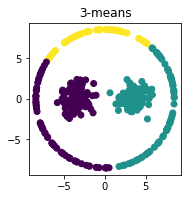

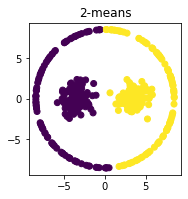

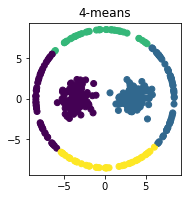

In [83]:
k3 = KMeans(n_clusters=3).fit(X)
plt.subplot(122, aspect='equal')
plt.scatter(X[:,0], X[:,1], c=k3.labels_)
plt.title('3-means')
plt.show()


k2 = KMeans(n_clusters=2).fit(X)
plt.subplot(122, aspect='equal')
plt.scatter(X[:,0], X[:,1], c=k2.labels_)
plt.title('2-means')
plt.show()


k4 = KMeans(n_clusters=4).fit(X)
plt.subplot(122, aspect='equal')
plt.scatter(X[:,0], X[:,1], c=k4.labels_)
plt.title('4-means')
plt.show()

### b)

In [474]:
def kneighbors_graph(X, num_neighbors, mutual=False):
    """ Generate k-neirest-neighbor graph
    
    Parameters
    ----------
    X: (n, d) numpy array
       Datapoints
    num_neighbors: int
       Number of nearest neighbors
       
    Returns
    -------
    W: (n, n) numpy array
        Adjacency matrix
    """

    W = sklearn.neighbors.kneighbors_graph(X, num_neighbors, include_self=False).toarray()
    
    if mutual:
        W = np.minimum(W,W.T)
    else:
        W = np.maximum(W, W.T)
    
    return W

In [475]:
# We define some points to test the kNN graph
X_test = np.array([[0, 0], 
                   [0, .2],
                   [1.5, 1],
                   [2, 1]])

assert_equal(kneighbors_graph(X_test, num_neighbors=2).shape, (4, 4))
assert_equal(kneighbors_graph(X_test, num_neighbors=3).shape, (4, 4))
assert_equal(np.unique(kneighbors_graph(X_test, num_neighbors=3)), [0, 1])
assert kneighbors_graph(X_test, num_neighbors=2).sum() < kneighbors_graph(X_test, num_neighbors=3).sum(),\
       "graph of k=3 should have more connections than k=2."

assert_equal(kneighbors_graph(X_test, num_neighbors=2),
             np.array([[0., 1., 1., 0.],
                       [1., 0., 1., 1.],
                       [1., 1., 0., 1.],
                       [0., 1., 1., 0.]]))

In [476]:
# plot a connected kNN graph
def plot_kneighbors_graph(X, k):
    A = kneighbors_graph(X, k)
    plt.subplots(figsize=(5,5))
    for x, a in zip(X, A):
        for y in X[a.astype(bool)]:
            plt.plot([x[0], y[0]], [x[1], y[1]], c='r')
    plt.plot(X[:, 0], X[:, 1], '.', zorder=10)

    n_connected, _ = scipy.sparse.csgraph.connected_components(A)
    plt.title('#Connected Components: {}'.format(n_connected))
    plt.suptitle('Symmetric kNN Graph')
    plt.show()

k_props = dict(min=1, max=50, continuous_update=False)

interact(plot_kneighbors_graph, X=fixed(X), k=widgets.IntSlider(**k_props));

interactive(children=(IntSlider(value=1, continuous_update=False, description='k', max=50, min=1), Output()), …

### c)

In [540]:
def spectral_cluster(W, k=None, normalize=False, regularization = 0):
    """ Spectral clustering algorithm
    
    Parameters
    ----------
    W: (n, n) numpy array
       Adjacency matrix
    k: int
       Number of cluster means
    normalise: bool
    regularization: float
        regularization of the adjacency
       
    Returns
    -------
    (X_embed, clustering, centers): (n, k), (n,), (k, k) numpy arrays
    """
    n = W.shape[0]
    
    if regularization:
        W = W + np.ones_like(W) * (regularization/n)
    
    d = W.sum(axis=0)
    D = d * np.identity(n)
    
    if normalize:
        D_12 = d**(-1/2) * np.identity(n)
        L = D_12 @ (D-W) @ D_12
    else:
        L = D-W
        
    eig_vals, eig_vecs = np.linalg.eig(L)
    if k == None:
        embedding = eig_vecs.real
        k=n
    else:
        embedding = eig_vecs[:,:k].real
    
    km = KMeans(k).fit(embedding)
    clustering = km.labels_
    centers = km.cluster_centers_
    
    assert embedding.shape == (n,k), f"Embedding shape is: {embedding.shape} - should: {(n,k)}"
    assert clustering.shape == (n,), f"Embedding shape is: {clustering.shape} - should: {(n,)}"
    assert centers.shape == (k,k), f"Embedding shape is: {centers.shape} - should: {(k,k)}"
    
    return embedding, clustering, centers
    

In [541]:
# testing correctness
embedding, clustering, centers = spectral_cluster(kneighbors_graph(X_test, 2), 3, normalize=False)

assert_equal(embedding.shape, (4, 3))
assert_equal(clustering.shape, (4,))
assert_equal(centers.shape, (3, 3))
assert_equal(np.unique(clustering), [0, 1, 2])
assert_almost_equal(np.linalg.norm(embedding, axis=0)**2, [1, 1, 1])

### (d)

If you did not solve (c), you can use sklearn's `SpectralClustering` instead of `spectral_cluster`.

In [542]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import SpectralClustering

Unnormalized Spectral Clustering:

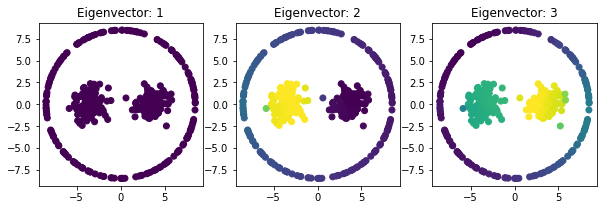

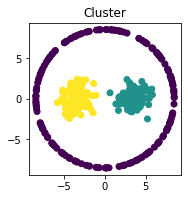

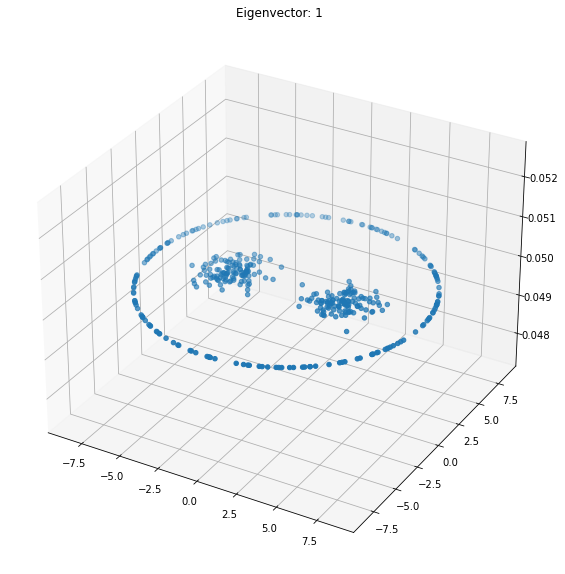

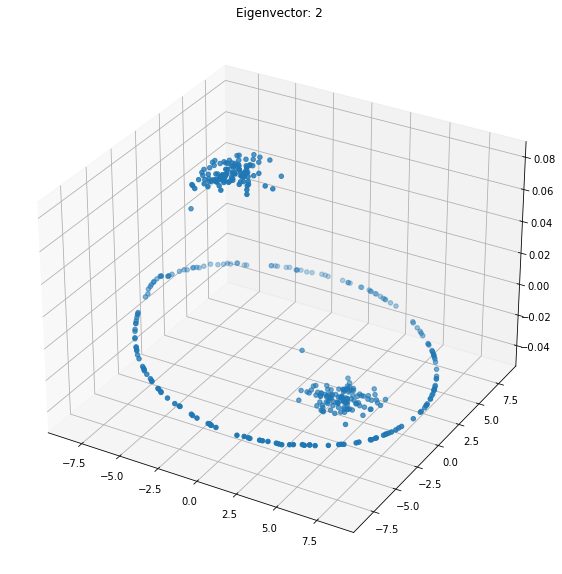

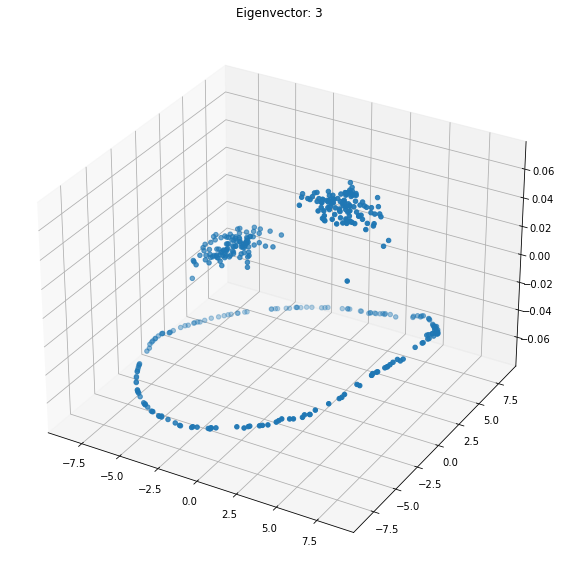

In [543]:
# Spectral clustering of X with reasonable k
def plot_spectral_clustering(X, k, init_k, normalize):
    k=k
    embedding, clustering, centers = spectral_cluster(kneighbors_graph(X, init_k), k, normalize=normalize)

    max_cols = 5
    cols = np.min([k,max_cols])
    rows = k // cols if k % cols == 0 else (k // cols)+1 

    fig, axs = plt.subplots(rows, cols, figsize=((3*cols)+1,3 * rows))
    axs = axs.flatten()
    # Plot clusters
    for j in range(k):
        # we round the embedding to 10 decimals in order to account floating point rounding errors
        # and to make sure eigenvector 1 does not have any differences in values in it
        axs[j].scatter(X[:,0], X[:,1], c=embedding[:,j].round(decimals=10)) 
        axs[j].set_title(f'Eigenvector: {j+1}')
    plt.show()

    plt.subplot(122, aspect='equal')
    plt.title('Cluster')
    plt.scatter(X[:,0], X[:,1], c=clustering) 

    # Plot 3d embedding
    for i in range(k):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        fig.set_size_inches((10,10))
        ax.scatter(X[:,0], X[:,1], embedding[:,i].round(decimals=10))
        ax.set_title(f'Eigenvector: {i+1}')
        plt.show()
        
plot_spectral_clustering(X, 3, 20, False)

Normalized Spectral Clustering:

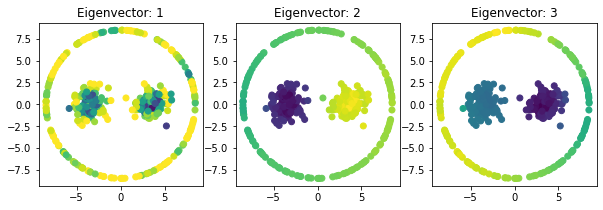

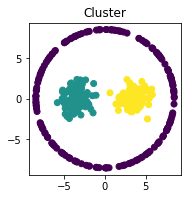

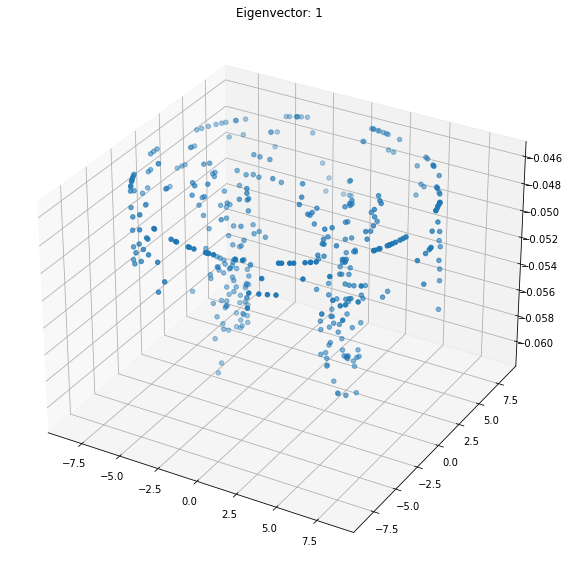

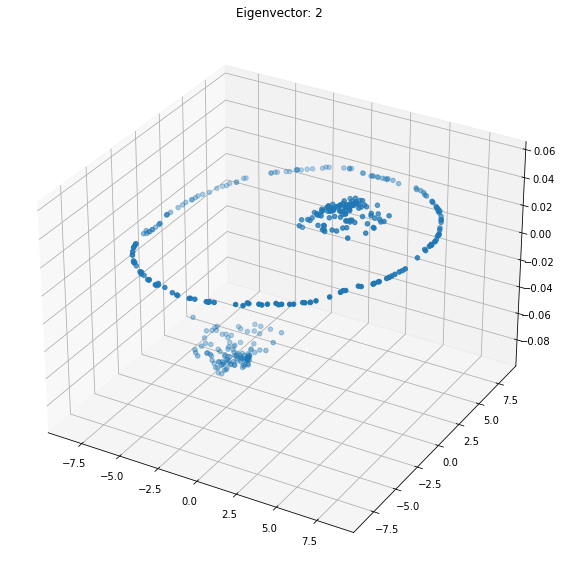

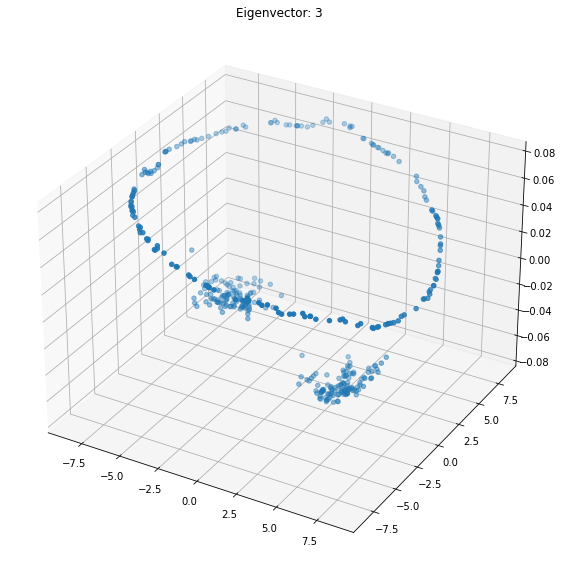

In [544]:
# Spectral clustering of X with reasonable k

plot_spectral_clustering(X, 3, 20, True)

In [548]:
def plot_pc_vals(X, num_neighbors=3, eigidx=0, normalize = True, regularization=0):
    ''' 
    Plot the embedding values per eigenvector of normalized spectral clustering.
        
    Parameters
    ----------
    X: input matrix
    num_neighbors: number of neighbors for each sample
    eigidx: index of the considered eigenvector
    regularization: regluarization of the adjacency
    '''
    k = 4
    embedding, clustering, centers = spectral_cluster(kneighbors_graph(X, num_neighbors), k=k, normalize=normalize, regularization=regularization)
    
    plt.plot(embedding[:,eigidx])
    #plt.colorbar()
    plt.title(f'Eigenvector {eigidx} of kNN Graph')
    plt.show()

In [549]:
# plot embedding values per eigenvector
k_props = dict(min=1, max=50, continuous_update=False)
eigidcs = dict(min=0, max=3, continuous_update=False)
reg = dict(min=0, max=50, continuous_update=False)

interact(plot_pc_vals, X=fixed(X),eigidx=widgets.IntSlider(**eigidcs), num_neighbors=widgets.IntSlider(**k_props), regularization=widgets.IntSlider(**reg));

interactive(children=(IntSlider(value=1, continuous_update=False, description='num_neighbors', max=50, min=1),…

In [551]:
W = np.load('sbm_adjacency.npy')
# choose the number of clusters


k_props = dict(min=1, max=700, continuous_update=False)
eigidcs = dict(min=0, max=10, continuous_update=False)
reg = dict(min=0, max=50, continuous_update=False)

interact(plot_pc_vals, X=fixed(W),eigidx=widgets.IntSlider(**eigidcs), num_neighbors=widgets.IntSlider(**k_props), regularization=widgets.IntSlider(**reg));


# estimate the number of nodes in each cluster
# YOUR CODE HERE

interactive(children=(IntSlider(value=1, continuous_update=False, description='num_neighbors', max=700, min=1)…

### Argumentation for selection procedure:

YOUR ANSWER HERE